# Data exploration
Halo reports from four Minneapolis public schools: Camden (Henry in the dataset), Anwatin, Anderson, and Roosevelt

## Cleaning

In [1]:
import pandas as pd
from datetime import datetime

csv_files = ['halo-report-data-csv/haloreport-2024-09-02-2024-12-02-copy.csv', 'halo-report-data-csv/haloreport-2024-12-03-2025-02-03-copy.csv',
            'halo-report-data-csv/haloreport-2025-02-03-2025-03-03-copy.csv', 'halo-report-data-csv/haloreport-2025-03-04-2025-04-15-copy.csv']
df = pd.DataFrame()

for file in csv_files:
    x = pd.read_csv(file)
    print(f'File has {x.shape[0]} rows')
    x['Date'] = pd.to_datetime(x['Date'], format='%m/%d/%Y')
    df = pd.concat([df, x], ignore_index=True)

print(f'Combined file has {df.shape[0]} rows')

File has 30277 rows
File has 777 rows
File has 5730 rows
File has 9040 rows
Combined file has 45824 rows


In [2]:
df.head()

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value
0,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,7:09:39 AM,7:10:19 AM,1730549379,126.16
1,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,7:11:41 AM,7:12:11 AM,1730549501,64.52
2,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,7:39:22 AM,7:39:52 AM,1730551162,40.88
3,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,9:58:32 AM,9:59:02 AM,1730559512,49.40
4,Site 1,Andersen_1st_Floor_B130_All_Gender,B0-B3-53-D1-76-BE,Vape,2024-11-02,9:59:28 AM,9:59:58 AM,1730559568,54.58


In [3]:
# Transform the dataset
df['School'] = df['Device'].apply(lambda x: x.split('_')[0])
df['Site'] = df['Device'].apply(lambda x: ' '.join(x.split('_')[1:]))
# Combine 'Date' with 'Start Time' and 'Stop Time'
df['Start Time'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Start Time'], format='%Y-%m-%d %I:%M:%S %p')
df['Stop Time'] = pd.to_datetime(df['Date'].dt.strftime('%Y-%m-%d') + ' ' + df['Stop Time'], format='%Y-%m-%d %I:%M:%S %p')
df['Duration'] = (df['Stop Time'] - df['Start Time']).dt.total_seconds()

In [4]:
df.to_csv('halo-report-data-csv/cleaned_halo_data.csv', index=False)

In [5]:
df.Device.unique()

array(['Andersen_1st_Floor_B130_All_Gender',
       'Andersen_2nd__Floor__C226_All_Gender',
       'Andersen_2nd_Floor_B226_All_Gender',
       'Andersen_2nd_Floor_Boys_D223_SE_Round',
       'Andersen_2nd_Floor_D201_Boys_SW_Round',
       'Andersen_2nd_Floor_D202_Girls_SW_Round',
       'Andersen_2nd_Floor_Girls_D221_SE_Round', 'Anwatin_Boys_407_#1',
       'Anwatin_Boys_407_#2', 'Anwatin_Girls_209_#1',
       'Anwatin_Girls_209_#2', 'Anwatin_Girls_418_#1',
       'Anwatin_Girls_418_#2',
       'Henry_1st_floor_stair_1_NW_Boys_restrooms',
       'Henry_1st_Floor_Stair_12_NE_Girls_Restrooms',
       'Henry_2nd_Floor_Stair_1_NW_Restroom_#3',
       'Henry_2nd_Floor_Stair_12_NE_Restrooms_#1',
       'Henry_2nd_Floor_Stair_14_SW_Restrooms_#1',
       'Henry_3RD_Floor_Stair_1_NW_Restroom_#1',
       'Henry_3rd_Floor_Stair_12_NE_Restrooms_#1',
       'Henry_3rd_Floor_Stair_14_SW_Restroom_#1',
       'Roosevelt_1st_floor_144_North_Sensor',
       'Roosevelt_1st_floor_144_South__Sensor',
    

## Exploratory analysis

Discoveries:
1. Each detected event usually lasts for around 30 to 40 seconds; multiple detected events may all refer to the same actual event (e.g., if a student smokes for 2 minutes, it'll show up as 4 detected events.) -> Suggestion: merge detected events that are 30 seconds apart from each other as the same actual event.

2. The relationship between the behavior type report and the halo report dataset remain unclear. Some disciplinary incident seems not to be based on detected events (e.g., teacher spotting vape falling out of a student's pocket.) Furthermore, many detected events seemed not to lead to any disciplinary incidents.


In [7]:
# Read the csv and segment by school
df = pd.read_csv('halo-report-data-csv/cleaned_halo_data.csv')
andersen_df = df[df['School'] == 'Andersen']
anwatin_df = df[df['School'] == 'Anwatin']
camden_df = df[df['School'] == 'Henry']
roosevelt_df = df[df['School'] == 'Roosevelt']

In [8]:
# Get some basic stats by school
alert_count = df.School.value_counts()
device_count = df.groupby(by='School').Device.nunique()
meta = pd.DataFrame({'alert_count': alert_count, 'device_count': device_count})
meta

,alert_count,device_count
School,,
Andersen,2107,8
Anwatin,786,7
Henry,21415,8
Roosevelt,21516,6


### General functions

In [ ]:
# Graph: Alert count by day (option: type)
import seaborn as sns
import matplotlib.pyplot as plt

def alert_count_by_day(df, type=None, save_path=None):
    # Group by 'Date' and the specified 'group', then count occurrences
    if type:
        date_count = df[df['Type']==type].Date.value_counts(sort=False)
    else:
        date_count = df.Date.value_counts(sort=False)

    plt.figure(figsize=(18, 6))
    sns.barplot(x=date_count.index, y=date_count.values)
    if type:
        plt.title(f'{df.School.unique()[0]} {type} Alert Count by Day', fontsize=16)
    else:
        plt.title(f'{df.School.unique()[0]} Alert Count by Day', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Alert Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

In [21]:
# Graph: grouped alert count by day
import seaborn as sns
import matplotlib.pyplot as plt

def grouped_alert_count_by_day(df, group, save_path=None):
    # Group by 'Date' and the specified 'group', then count occurrences
    date_counts = df.groupby(['Date', group]).size().reset_index(name='count')
    
    plt.figure(figsize=(18, 6))
    sns.barplot(x='Date', y='count', hue=group, data=date_counts, palette='Set2')
    plt.legend()

    plt.title(f'{df.School.unique()[0]} Grouped Alert Count by Day', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Alert Count', fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path)
    else:
        plt.show()

### Andersen

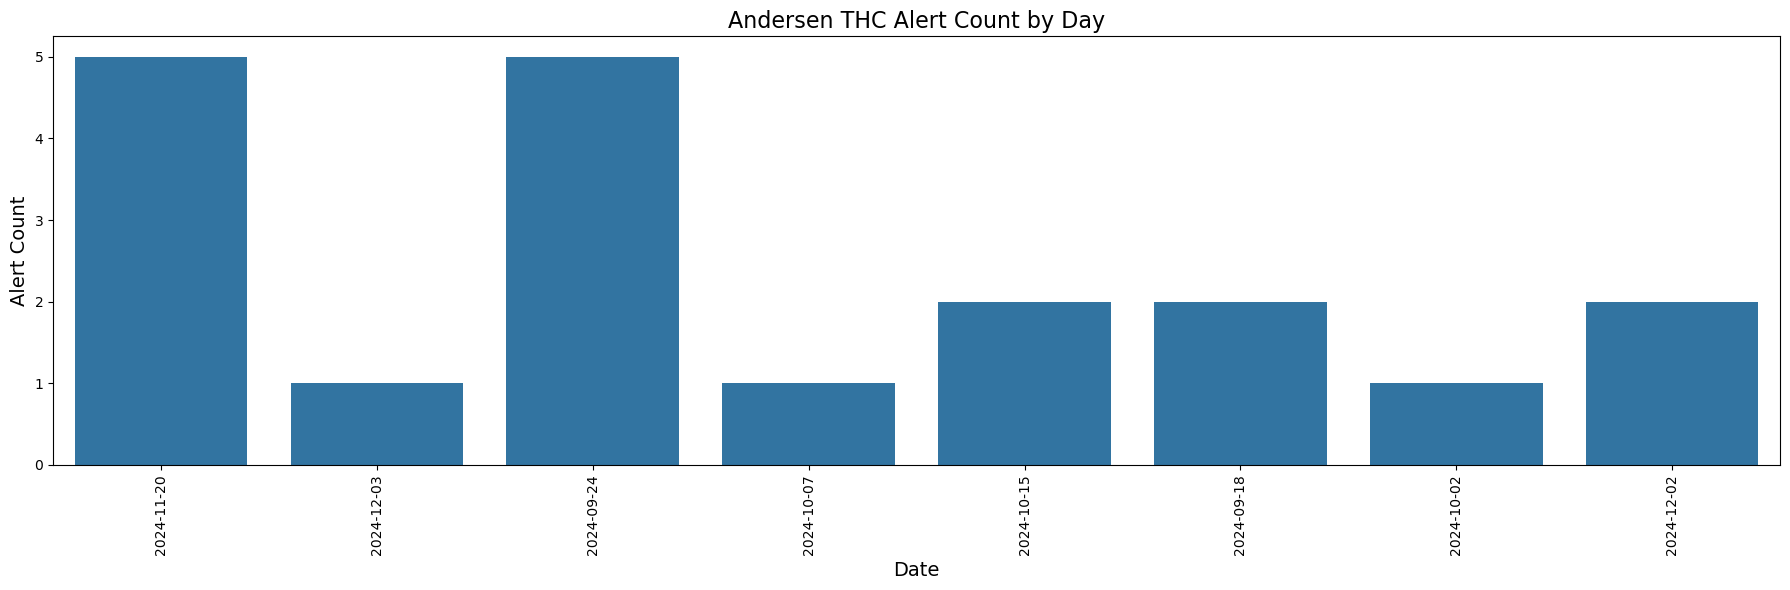

In [32]:
alert_count_by_day(andersen_df, type='THC')

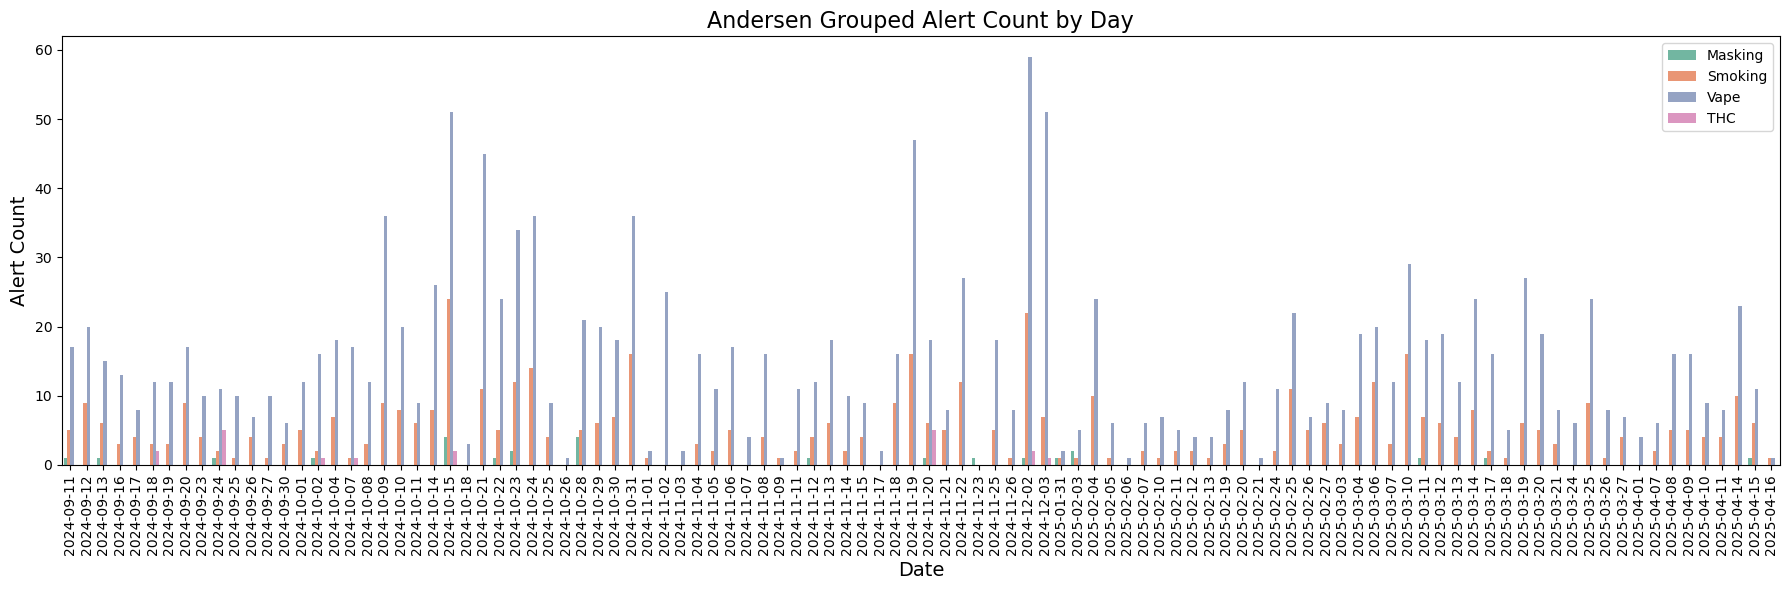

In [12]:
grouped_alert_count_by_day(andersen_df, 'Type')

According to the behavior type report, Andersen Middle saw 14 events of vaping (with 16 students caught).
The events happened on (mm/dd/YY):
- 04/08/25
- 03/03/25
- 02/13/25 (same event with two students)
- 02/07/25 (same event with one student, seemed to be double counted)
- 12/17/24 (same event with one student, seemed to be double counted)
- 11/07/24
- 10/28/24
- 10/23/24
- 10/22/24
- 09/10/24 (same event but two students)
- 09/09/24
- 09/03/24


In [35]:
andersen_df[andersen_df['Date'] == '2025-02-13'].sort_values(by='Start Time', ascending=False)

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration
31070,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Smoking,2025-02-13,2025-02-13 15:12:57,2025-02-13 15:13:27,1739481177,-110.44,Andersen,30.0
31069,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2025-02-13,2025-02-13 15:12:32,2025-02-13 15:13:02,1739481152,831.15,Andersen,30.0
31152,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2025-02-13,2025-02-13 13:04:55,2025-02-13 13:05:25,1739473495,101.42,Andersen,30.0
31151,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2025-02-13,2025-02-13 10:04:35,2025-02-13 10:05:05,1739462675,54.00,Andersen,30.0
31150,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2025-02-13,2025-02-13 10:03:08,2025-02-13 10:03:38,1739462588,246.13,Andersen,30.0


In [37]:
andersen_df[andersen_df['Type'] == 'Masking'].Date.unique()

array(['2024-09-13', '2024-10-23', '2024-10-28', '2024-11-12',
       '2024-10-02', '2024-11-20', '2024-11-23', '2024-09-24',
       '2024-10-15', '2024-09-11', '2024-10-22', '2024-12-02',
       '2025-01-31', '2025-02-03', '2025-04-15', '2025-03-11',
       '2025-03-17'], dtype=object)

In [39]:
andersen_df[andersen_df['Date']=='2024-10-23'].sort_values(by='Start Time', ascending=False)

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration
155,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-23,2024-10-23 20:29:35,2024-10-23 20:30:05,1729733375,76.28,Andersen,30.0
1255,2nd Floor Girls D221 SE Round,Andersen_2nd_Floor_Girls_D221_SE_Round,B0-B3-53-D1-76-8F,Vape,2024-10-23,2024-10-23 16:52:37,2024-10-23 16:53:07,1729720357,50.08,Andersen,30.0
1254,2nd Floor Girls D221 SE Round,Andersen_2nd_Floor_Girls_D221_SE_Round,B0-B3-53-D1-76-8F,Smoking,2024-10-23,2024-10-23 16:46:56,2024-10-23 16:47:26,1729720016,18.72,Andersen,30.0
1253,2nd Floor Girls D221 SE Round,Andersen_2nd_Floor_Girls_D221_SE_Round,B0-B3-53-D1-76-8F,Vape,2024-10-23,2024-10-23 16:46:31,2024-10-23 16:47:01,1729719991,975.66,Andersen,30.0
460,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:22:51,2024-10-23 15:23:21,1729714971,103.46,Andersen,30.0
459,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:20:48,2024-10-23 15:21:18,1729714848,112.84,Andersen,30.0
458,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Smoking,2024-10-23,2024-10-23 15:20:07,2024-10-23 15:20:37,1729714807,-79.64,Andersen,30.0
457,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:19:42,2024-10-23 15:20:12,1729714782,226.30,Andersen,30.0
456,2nd Floor Boys D223 SE Round,Andersen_2nd_Floor_Boys_D223_SE_Round,B0-B3-53-D1-29-53,Vape,2024-10-23,2024-10-23 15:15:54,2024-10-23 15:16:24,1729714554,145.79,Andersen,30.0
686,2nd Floor D201 Boys SW Round,Andersen_2nd_Floor_D201_Boys_SW_Round,B0-B3-53-D1-76-1D,Vape,2024-10-23,2024-10-23 14:31:48,2024-10-23 14:32:18,1729711908,41.36,Andersen,30.0


In [42]:
andersen_df.Date.sort_values(ascending=True).unique()

array(['2024-09-11', '2024-09-12', '2024-09-13', '2024-09-16',
       '2024-09-17', '2024-09-18', '2024-09-19', '2024-09-20',
       '2024-09-23', '2024-09-24', '2024-09-25', '2024-09-26',
       '2024-09-27', '2024-09-30', '2024-10-01', '2024-10-02',
       '2024-10-04', '2024-10-07', '2024-10-08', '2024-10-09',
       '2024-10-10', '2024-10-11', '2024-10-14', '2024-10-15',
       '2024-10-18', '2024-10-21', '2024-10-22', '2024-10-23',
       '2024-10-24', '2024-10-25', '2024-10-26', '2024-10-28',
       '2024-10-29', '2024-10-30', '2024-10-31', '2024-11-01',
       '2024-11-02', '2024-11-03', '2024-11-04', '2024-11-05',
       '2024-11-06', '2024-11-07', '2024-11-08', '2024-11-09',
       '2024-11-11', '2024-11-12', '2024-11-13', '2024-11-14',
       '2024-11-15', '2024-11-17', '2024-11-18', '2024-11-19',
       '2024-11-20', '2024-11-21', '2024-11-22', '2024-11-23',
       '2024-11-25', '2024-11-26', '2024-12-02', '2024-12-03',
       '2025-01-31', '2025-02-03', '2025-02-04', '2025-

In [44]:
andersen_df[andersen_df['Date'] == '2024-10-28']

,Site,Device,MAC,Type,Date,Start Time,Stop Time,Timestamp,Value,School,Duration
160,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 19:21:37,2024-10-28 19:22:07,1730161297,122.11,Andersen,30.0
161,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 23:26:38,2024-10-28 23:27:08,1730175998,506.33,Andersen,30.0
162,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Masking,2024-10-28,2024-10-28 23:28:24,2024-10-28 23:28:54,1730176104,68.87,Andersen,30.0
163,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Masking,2024-10-28,2024-10-28 23:29:30,2024-10-28 23:30:00,1730176170,167.24,Andersen,30.0
164,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Masking,2024-10-28,2024-10-28 23:32:01,2024-10-28 23:32:31,1730176321,39.70,Andersen,30.0
165,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 23:40:00,2024-10-28 23:40:30,1730176800,61.02,Andersen,30.0
166,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 23:40:50,2024-10-28 23:41:24,1730176850,161.43,Andersen,34.0
167,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 23:42:30,2024-10-28 23:43:00,1730176950,153.54,Andersen,30.0
168,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 23:44:31,2024-10-28 23:45:01,1730177071,160.73,Andersen,30.0
169,2nd Floor C226 All Gender,Andersen_2nd__Floor__C226_All_Gender,B0-B3-53-D1-76-26,Vape,2024-10-28,2024-10-28 23:45:33,2024-10-28 23:46:03,1730177133,38.28,Andersen,30.0


### Anwatin

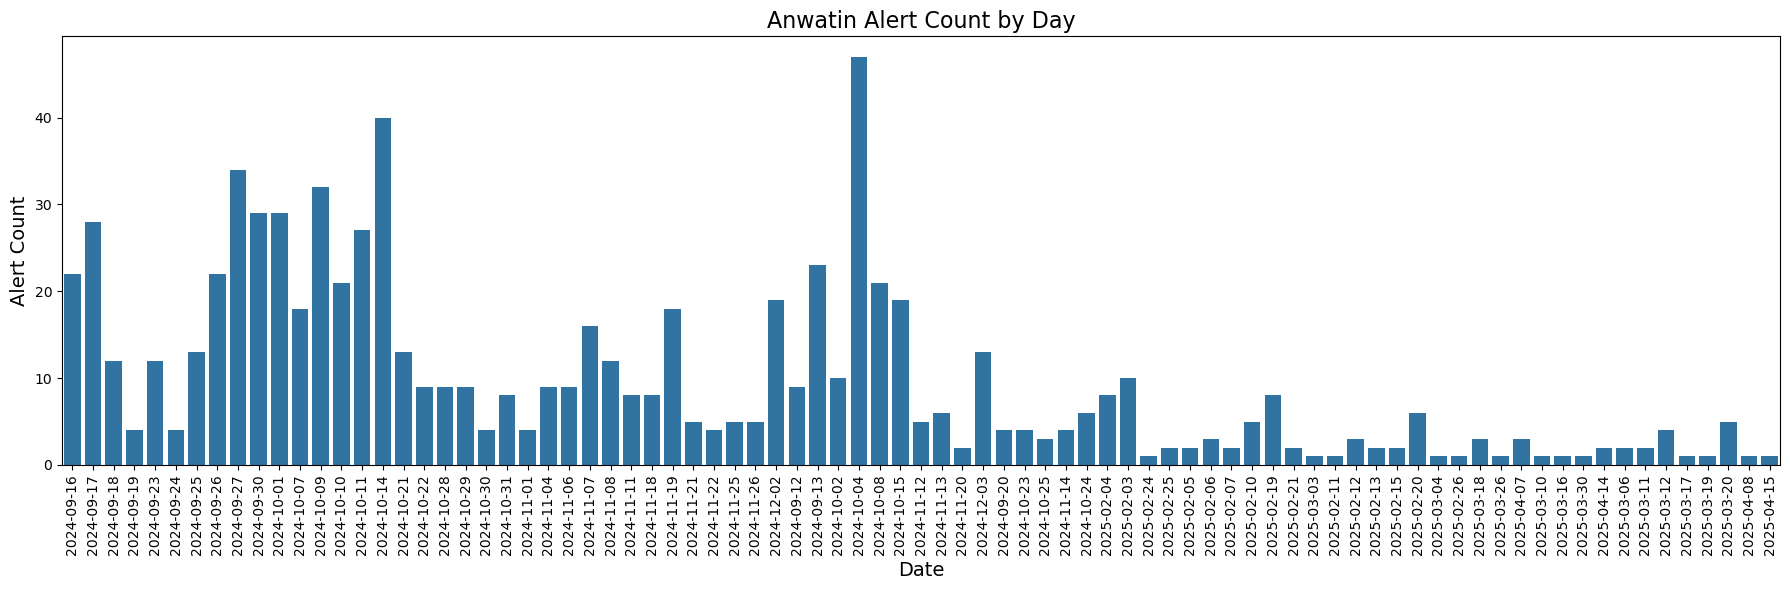

In [13]:
alert_count_by_day(anwatin_df)

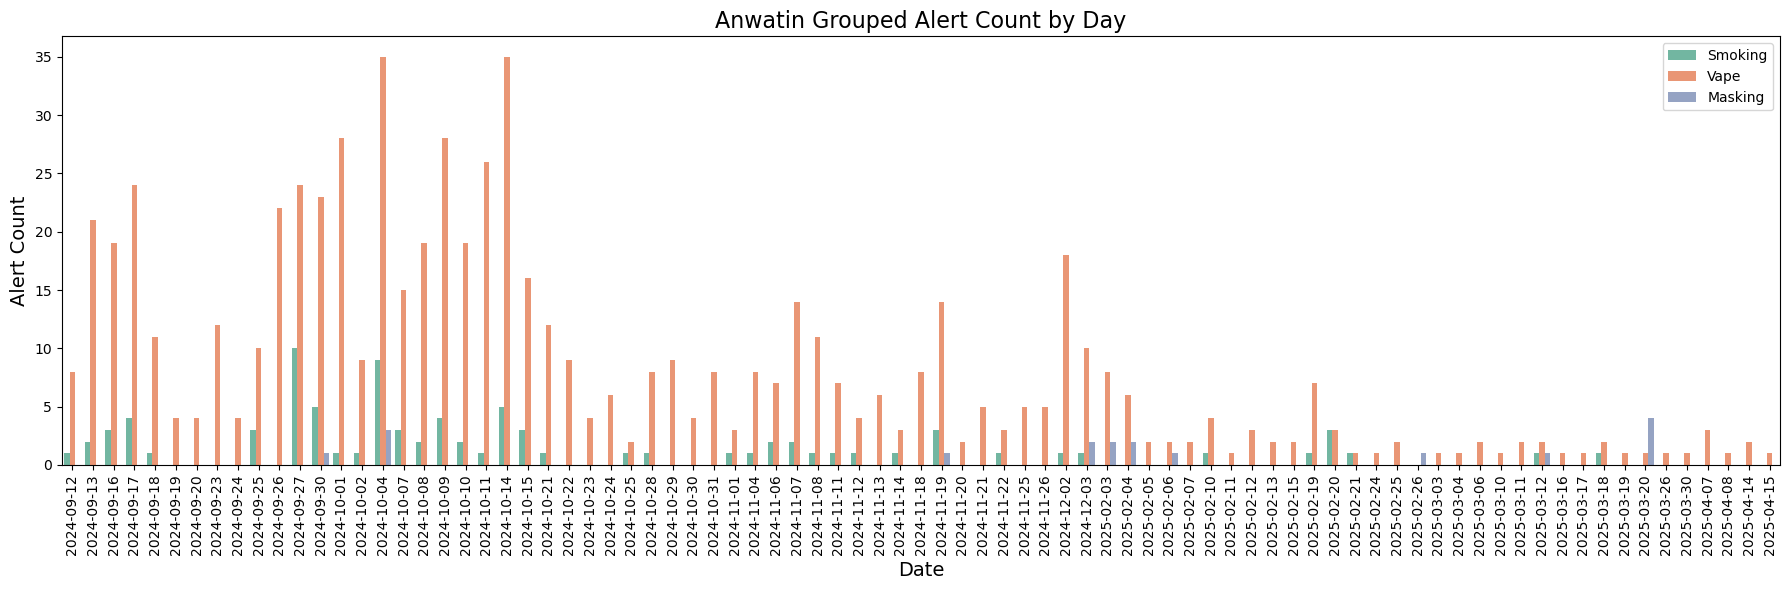

In [14]:
grouped_alert_count_by_day(anwatin_df, 'Type')

### Camden (Henry)

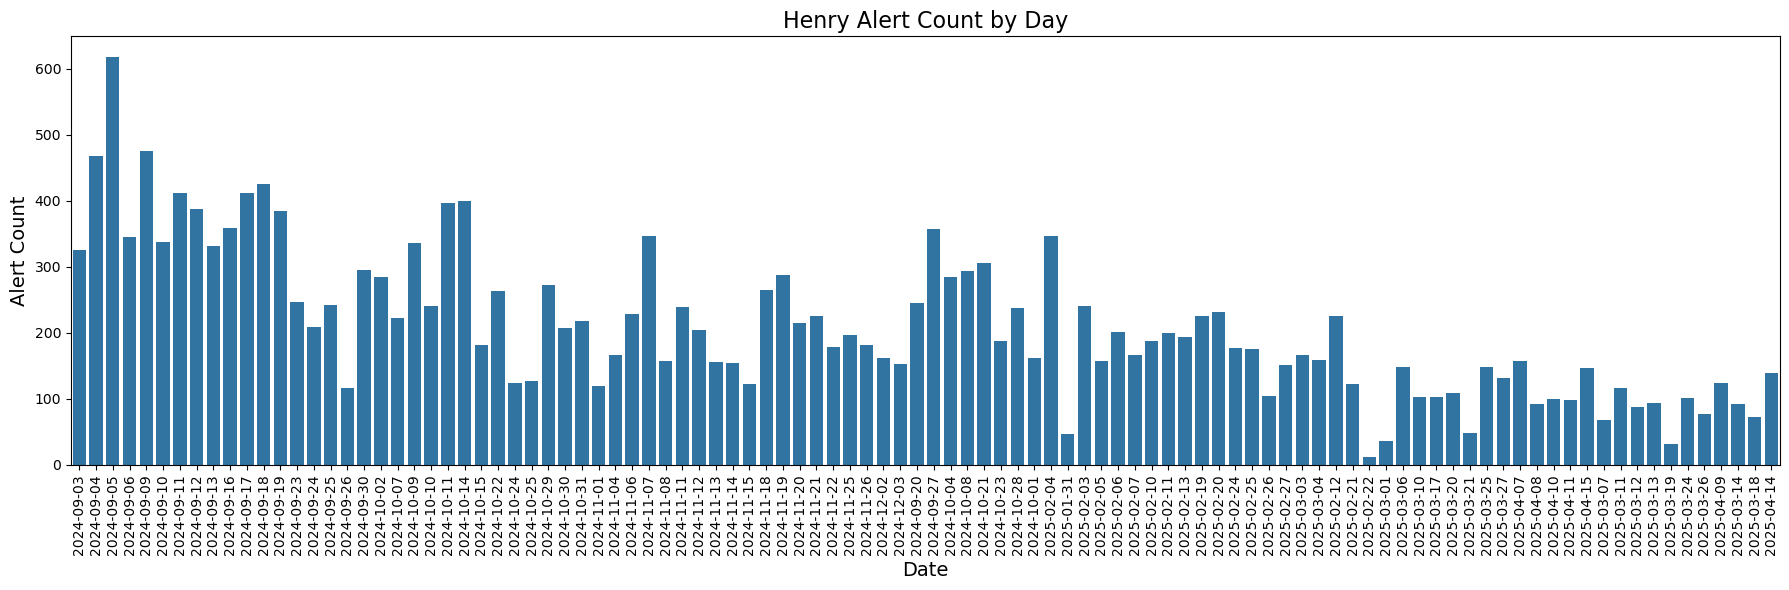

In [15]:
alert_count_by_day(camden_df)

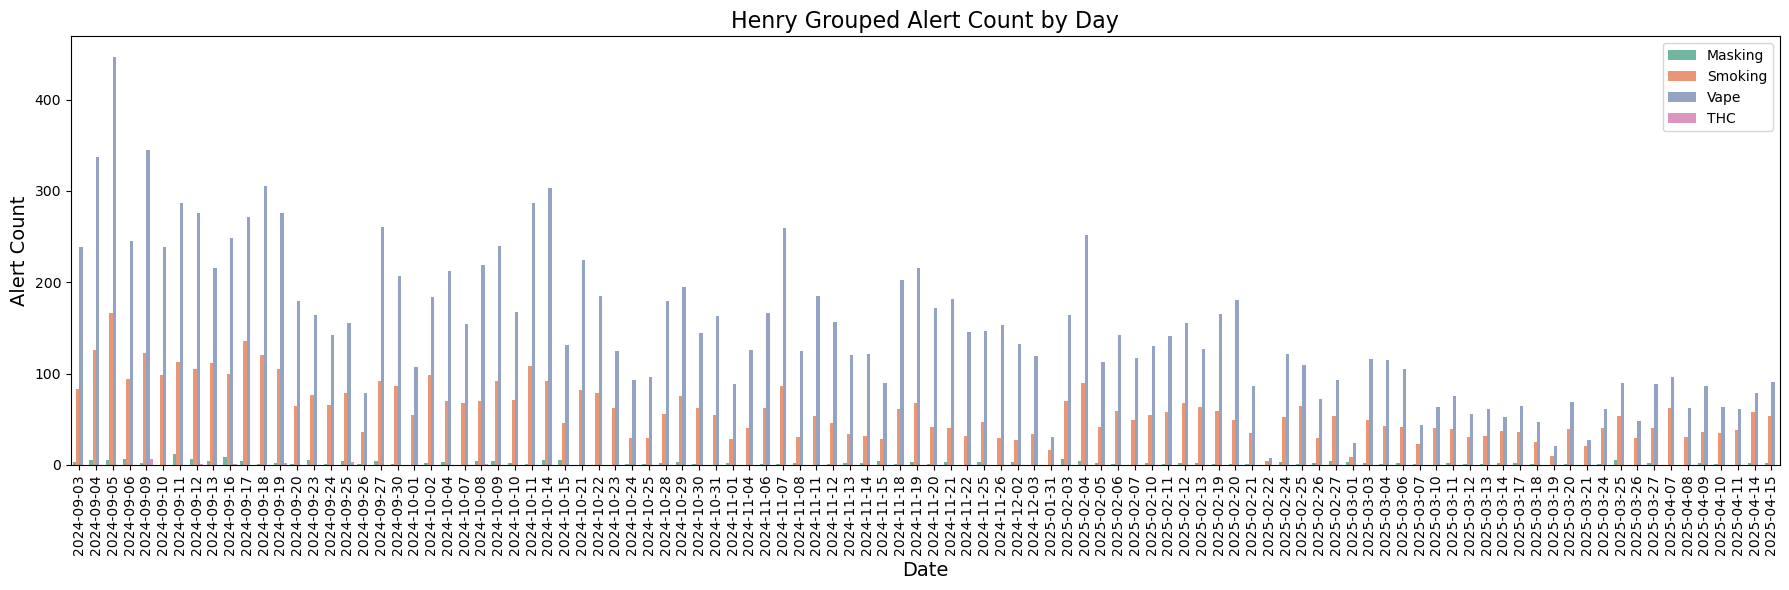

In [16]:
grouped_alert_count_by_day(camden_df, 'Type')

### Roosevelt

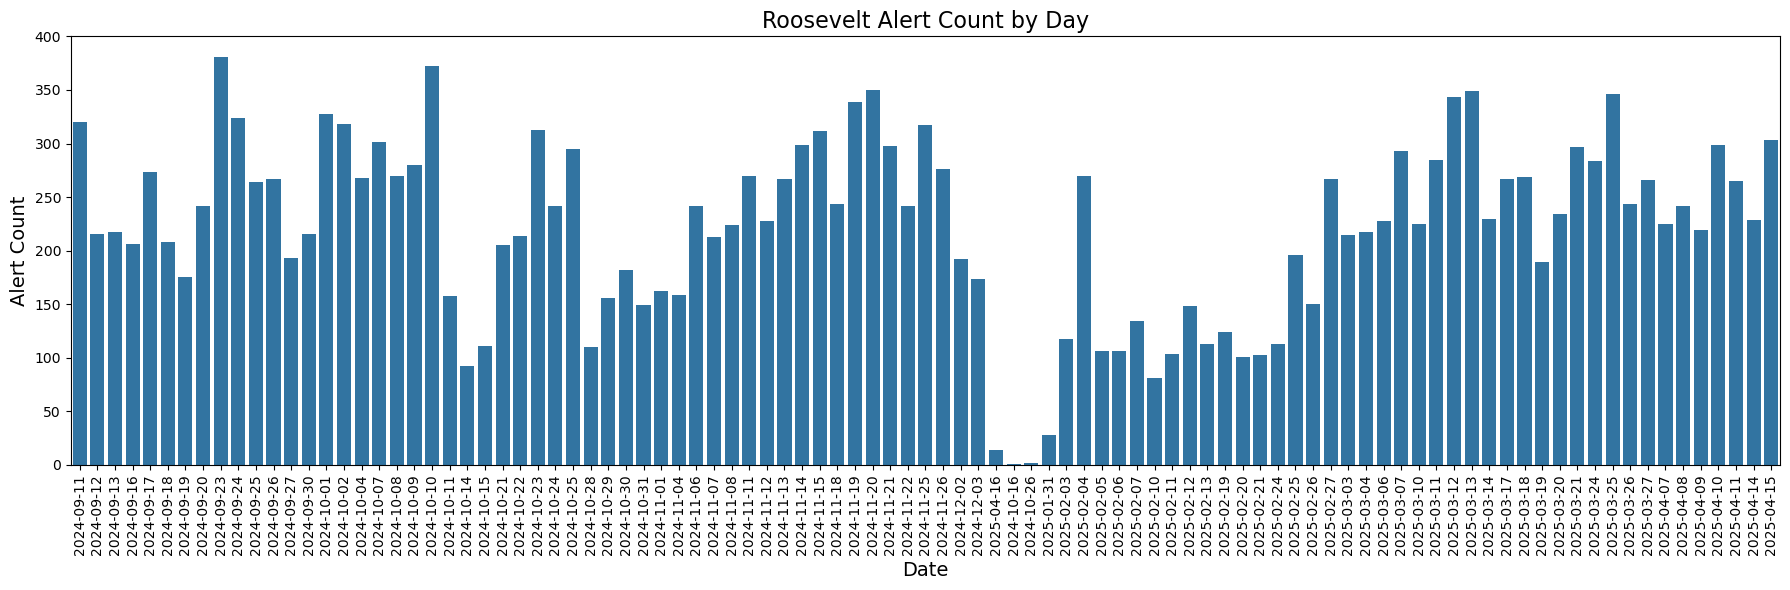

In [17]:
alert_count_by_day(roosevelt_df)

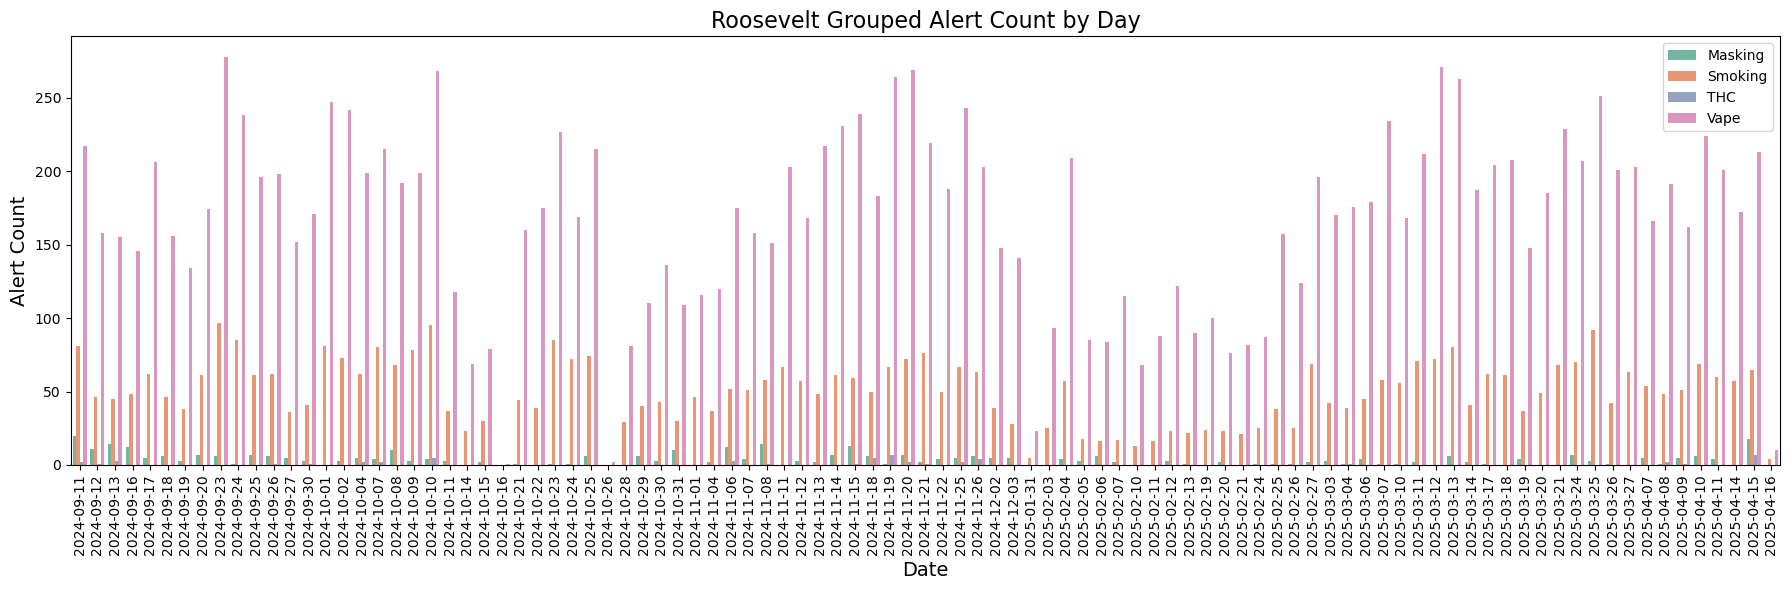

In [18]:
grouped_alert_count_by_day(roosevelt_df, 'Type')